<a href="https://colab.research.google.com/github/Int-Group-44/flowers-102/blob/main/OxfordFlowers102CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
dataset_info
test_set, training_set, validation_set = dataset['test'], dataset['train'], dataset['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteZJJ29I/oxford_flowers102-train.tfrecord*…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteZJJ29I/oxford_flowers102-test.tfrecord*.…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteZJJ29I/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [2]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

print(gpus)

Physical devices cannot be modified after being initialized
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Importing TensorFlow 

In [3]:
num_classes = dataset_info.features['label'].num_classes
num_training_examples = 1020
num_validation_examples = 1020

In [4]:
IMAGE_RES = 224

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    #label = tf.one_hot(label, depth=num_classes)
    return image, label
BATCH_SIZE = 16
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.shuffle(num_validation_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_set.map(format_image).batch(BATCH_SIZE).prefetch(1)


In [5]:
def make_model(input_shape, num_classes):
  model = tf.keras.Sequential()
  model.add(layers.RandomFlip("horizontal_and_vertical", input_shape=input_shape))
  model.add(layers.RandomRotation(20))
  model.add(layers.RandomZoom(0.2))
  model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(512, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(512, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(0.35))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.35))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.35))
  model.add(layers.Dense(num_classes))
  return model


In [6]:
tf.keras.backend.clear_session()
model = make_model(input_shape=(IMAGE_RES, IMAGE_RES) + (3,), num_classes=102)

In [7]:

#keras.utils.plot_model(model, show_shapes=True)

epochs = 150

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000075),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_batches,
    epochs=epochs,
    validation_data=validation_batches,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    verbose=1
    #callbacks=[reduce_lr]
)

Epoch 1/150
64/64 [==============================] - 34s 183ms/step - loss: 5.6702 - accuracy: 0.0108 - val_loss: 4.6729 - val_accuracy: 0.0098
Epoch 2/150
64/64 [==============================] - 10s 138ms/step - loss: 4.8874 - accuracy: 0.0127 - val_loss: 4.7015 - val_accuracy: 0.0098
Epoch 3/150
64/64 [==============================] - 10s 144ms/step - loss: 4.7455 - accuracy: 0.0176 - val_loss: 4.6724 - val_accuracy: 0.0098
Epoch 4/150
64/64 [==============================] - 10s 149ms/step - loss: 4.6959 - accuracy: 0.0167 - val_loss: 4.6564 - val_accuracy: 0.0078
Epoch 5/150
64/64 [==============================] - 13s 184ms/step - loss: 4.6429 - accuracy: 0.0186 - val_loss: 4.6687 - val_accuracy: 0.0098
Epoch 6/150
64/64 [==============================] - 9s 142ms/step - loss: 4.6262 - accuracy: 0.0167 - val_loss: 4.6370 - val_accuracy: 0.0216
Epoch 7/150
64/64 [==============================] - 10s 147ms/step - loss: 4.5862 - accuracy: 0.0176 - val_loss: 4.5284 - val_accuracy: 

In [8]:
tloss1 = history.history['loss']
vloss1 = history.history['val_loss']
tacc1 = history.history['accuracy']
vacc1 = history.history['val_accuracy']

In [9]:

#keras.shutils.plot_model(model, ow_shapes=True)

epochs = 125

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_batches,
    epochs=epochs,
    validation_data=validation_batches,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    verbose=1
    #callbacks=[reduce_lr]
)

Epoch 1/125
64/64 [==============================] - 18s 150ms/step - loss: 0.9528 - accuracy: 0.7333 - val_loss: 2.7615 - val_accuracy: 0.4725
Epoch 2/125
64/64 [==============================] - 10s 146ms/step - loss: 0.8947 - accuracy: 0.7461 - val_loss: 2.6897 - val_accuracy: 0.4745
Epoch 3/125
64/64 [==============================] - 12s 185ms/step - loss: 0.7561 - accuracy: 0.7824 - val_loss: 2.7994 - val_accuracy: 0.4863
Epoch 4/125
64/64 [==============================] - 10s 147ms/step - loss: 0.7768 - accuracy: 0.7775 - val_loss: 3.0641 - val_accuracy: 0.4500
Epoch 5/125
64/64 [==============================] - 10s 144ms/step - loss: 0.7876 - accuracy: 0.7598 - val_loss: 2.7362 - val_accuracy: 0.4951
Epoch 6/125
64/64 [==============================] - 9s 139ms/step - loss: 0.7858 - accuracy: 0.7657 - val_loss: 2.8204 - val_accuracy: 0.4618
Epoch 7/125
64/64 [==============================] - 9s 140ms/step - loss: 0.7745 - accuracy: 0.7598 - val_loss: 2.7715 - val_accuracy: 0

In [10]:
tloss2 = history.history['loss']
vloss2 = history.history['val_loss']
tacc2 = history.history['accuracy']
vacc2 = history.history['val_accuracy']

In [11]:
epochs = 100

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000025),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_batches,
    epochs=epochs,
    validation_data=validation_batches,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    verbose=1
    #callbacks=[reduce_lr]
)

Epoch 1/100
64/64 [==============================] - 17s 141ms/step - loss: 0.2437 - accuracy: 0.9294 - val_loss: 3.2403 - val_accuracy: 0.5157
Epoch 2/100
64/64 [==============================] - 9s 137ms/step - loss: 0.2308 - accuracy: 0.9235 - val_loss: 3.3030 - val_accuracy: 0.5245
Epoch 3/100
64/64 [==============================] - 9s 142ms/step - loss: 0.2107 - accuracy: 0.9441 - val_loss: 3.2919 - val_accuracy: 0.5216
Epoch 4/100
64/64 [==============================] - 9s 144ms/step - loss: 0.2155 - accuracy: 0.9343 - val_loss: 3.3261 - val_accuracy: 0.5382
Epoch 5/100
64/64 [==============================] - 9s 136ms/step - loss: 0.2053 - accuracy: 0.9451 - val_loss: 3.3500 - val_accuracy: 0.5314
Epoch 6/100
64/64 [==============================] - 9s 139ms/step - loss: 0.1646 - accuracy: 0.9539 - val_loss: 3.3715 - val_accuracy: 0.5265
Epoch 7/100
64/64 [==============================] - 10s 145ms/step - loss: 0.1574 - accuracy: 0.9520 - val_loss: 3.4713 - val_accuracy: 0.50

In [12]:
tloss3 = history.history['loss']
vloss3 = history.history['val_loss']
tacc3 = history.history['accuracy']
vacc3 = history.history['val_accuracy']

In [13]:
epochs = 75

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0000175),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_batches,
    epochs=epochs,
    validation_data=validation_batches,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    verbose=1
    #callbacks=[reduce_lr]
)

Epoch 1/75
64/64 [==============================] - 18s 143ms/step - loss: 0.1112 - accuracy: 0.9755 - val_loss: 3.7703 - val_accuracy: 0.5324
Epoch 2/75
64/64 [==============================] - 10s 144ms/step - loss: 0.0839 - accuracy: 0.9745 - val_loss: 3.8550 - val_accuracy: 0.5392
Epoch 3/75
64/64 [==============================] - 9s 142ms/step - loss: 0.1021 - accuracy: 0.9716 - val_loss: 3.6107 - val_accuracy: 0.5510
Epoch 4/75
64/64 [==============================] - 10s 147ms/step - loss: 0.0725 - accuracy: 0.9765 - val_loss: 3.5558 - val_accuracy: 0.5480
Epoch 5/75
64/64 [==============================] - 10s 152ms/step - loss: 0.0890 - accuracy: 0.9765 - val_loss: 3.5914 - val_accuracy: 0.5578
Epoch 6/75
64/64 [==============================] - 9s 134ms/step - loss: 0.0995 - accuracy: 0.9676 - val_loss: 3.6586 - val_accuracy: 0.5471
Epoch 7/75
64/64 [==============================] - 9s 136ms/step - loss: 0.0939 - accuracy: 0.9706 - val_loss: 3.6393 - val_accuracy: 0.5539
Ep

In [14]:
tloss4 = history.history['loss']
vloss4 = history.history['val_loss']
tacc4 = history.history['accuracy']
vacc4 = history.history['val_accuracy']

In [15]:
epochs = 50

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00000875),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_batches,
    epochs=epochs,
    validation_data=validation_batches,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    verbose=1
    #callbacks=[reduce_lr]
)

Epoch 1/50
64/64 [==============================] - 19s 141ms/step - loss: 0.0883 - accuracy: 0.9696 - val_loss: 3.5537 - val_accuracy: 0.5520
Epoch 2/50
64/64 [==============================] - 10s 138ms/step - loss: 0.0574 - accuracy: 0.9833 - val_loss: 3.6103 - val_accuracy: 0.5451
Epoch 3/50
64/64 [==============================] - 9s 138ms/step - loss: 0.0512 - accuracy: 0.9833 - val_loss: 3.6516 - val_accuracy: 0.5490
Epoch 4/50
64/64 [==============================] - 10s 146ms/step - loss: 0.0773 - accuracy: 0.9794 - val_loss: 3.6943 - val_accuracy: 0.5529
Epoch 5/50
64/64 [==============================] - 12s 184ms/step - loss: 0.0446 - accuracy: 0.9863 - val_loss: 3.6600 - val_accuracy: 0.5569
Epoch 6/50
64/64 [==============================] - 12s 184ms/step - loss: 0.0674 - accuracy: 0.9784 - val_loss: 3.6897 - val_accuracy: 0.5549
Epoch 7/50
64/64 [==============================] - 9s 134ms/step - loss: 0.0540 - accuracy: 0.9853 - val_loss: 3.6939 - val_accuracy: 0.5559
E

In [16]:
tloss5 = history.history['loss']
vloss5 = history.history['val_loss']
tacc5 = history.history['accuracy']
vacc5 = history.history['val_accuracy']

In [17]:
epochs = 25

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000004375),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_batches,
    epochs=epochs,
    validation_data=validation_batches,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    verbose=1
    #callbacks=[reduce_lr]
)

Epoch 1/25
64/64 [==============================] - 19s 157ms/step - loss: 0.0480 - accuracy: 0.9892 - val_loss: 3.8928 - val_accuracy: 0.5480
Epoch 2/25
64/64 [==============================] - 9s 139ms/step - loss: 0.0439 - accuracy: 0.9824 - val_loss: 3.8974 - val_accuracy: 0.5539
Epoch 3/25
64/64 [==============================] - 10s 155ms/step - loss: 0.0590 - accuracy: 0.9814 - val_loss: 3.8449 - val_accuracy: 0.5480
Epoch 4/25
64/64 [==============================] - 9s 136ms/step - loss: 0.0413 - accuracy: 0.9873 - val_loss: 3.8017 - val_accuracy: 0.5549
Epoch 5/25
64/64 [==============================] - 9s 139ms/step - loss: 0.0553 - accuracy: 0.9814 - val_loss: 3.8064 - val_accuracy: 0.5539
Epoch 6/25
64/64 [==============================] - 9s 140ms/step - loss: 0.0549 - accuracy: 0.9824 - val_loss: 3.7898 - val_accuracy: 0.5529
Epoch 7/25
64/64 [==============================] - 12s 184ms/step - loss: 0.0542 - accuracy: 0.9833 - val_loss: 3.7914 - val_accuracy: 0.5490
Epo

In [18]:
tloss6 = history.history['loss']
vloss6 = history.history['val_loss']
tacc6 = history.history['accuracy']
vacc6 = history.history['val_accuracy']

In [19]:
model.save('OxfordFlowers102-2.keras')

In [20]:
test_loss, test_acc = model.evaluate(test_batches, verbose=1, batch_size=BATCH_SIZE)
print("Test accuracy:", test_acc)

385/385 [==============================] - 14s 36ms/step - loss: 3.9707 - accuracy: 0.5102
Test accuracy: 0.5101642608642578


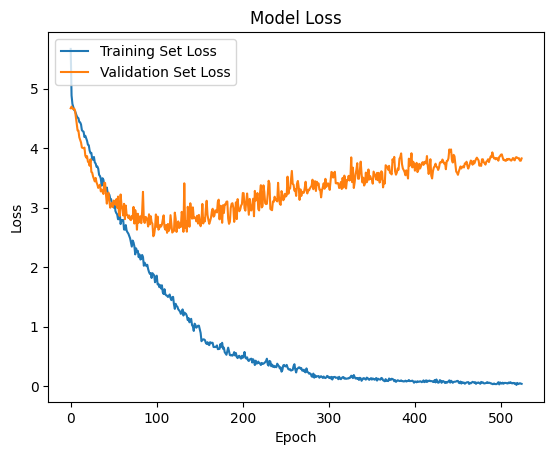

In [21]:
plt.plot(tloss1 + tloss2 + tloss3 + tloss4 + tloss5 + tloss6)
#plt.ylim(0,10)
plt.plot(vloss1 + vloss2 + vloss3 + vloss4 + vloss5 + vloss6)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set Loss','Validation Set Loss'], loc="upper left")
plt.show()

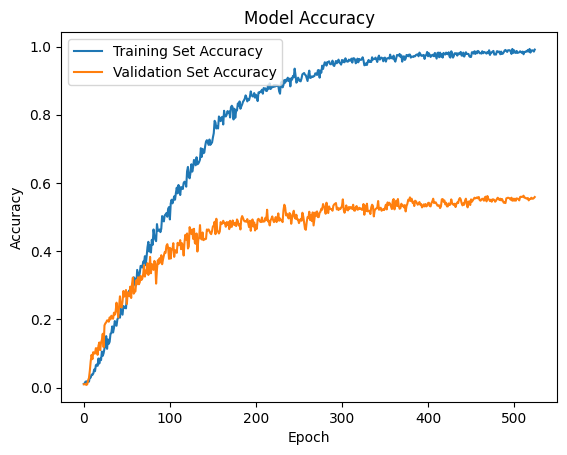

In [22]:
plt.plot(tacc1 + tacc2 + tacc3 + tacc4 + tacc5 +tacc6)
plt.plot(vacc1 + vacc2 + vacc3 + vacc4 + vacc5 +vacc6)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set Accuracy','Validation Set Accuracy'], loc="upper left")
plt.show()

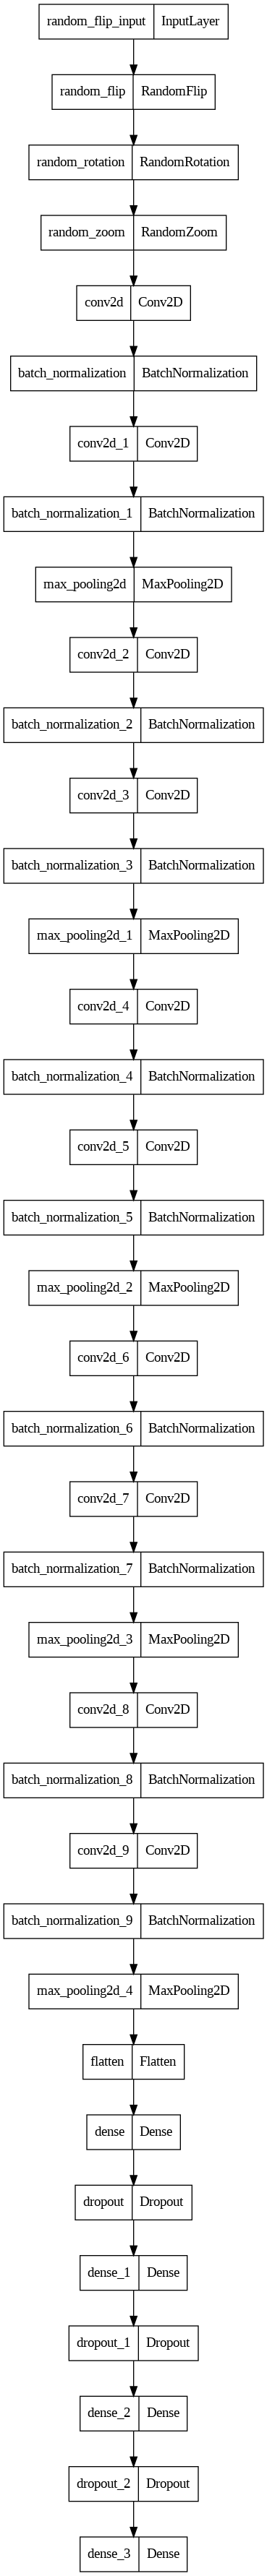

In [23]:
tf.keras.utils.plot_model(model)

In [26]:
model.save('/main/')